# Data Glacier Internship Group Project: Bank Marketing Campaign

## Predicting Whether a Client Will Subscribe for a Term Deposit

In [2]:
#Importing packages that we might need
#If you want to import more packages, just do it here

import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

### Loading the Data

In [3]:
bank = pd.read_csv('data/bank.csv', sep = ';', header = 0) #smaller dataframe
bank_full = pd.read_csv('data/bank-full.csv', sep = ';', header = 0) #full dataframe

In [4]:
bank.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


In [5]:
bank_full.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


### Inspecting the Data, Looking for Problems in the Data

#### Looking for Missing/NA Values

In [6]:
print("Missing values in the small dataframe:", bank.isnull().sum().sum())
print("Missing values in the full dataframe:", bank_full.isnull().sum().sum())

#seems a little weird that there's no missing values in the whole dataset, someone else double check this

Missing values in the small dataframe: 0
Missing values in the full dataframe: 0


There are no missing values in either of the datasets, so we will not need to deal with missing data

#### Looking for Outliers and Skewed Variables

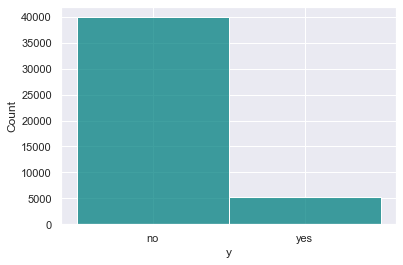

In [19]:
y_hist = sns.histplot(data=bank_full, x = 'y', color = 'teal')

The dataset is imbalanced, there are significantly more 'no' than 'yes'

array([[<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'balance'}>,
        <AxesSubplot:title={'center':'day'}>],
       [<AxesSubplot:title={'center':'duration'}>,
        <AxesSubplot:title={'center':'campaign'}>,
        <AxesSubplot:title={'center':'pdays'}>],
       [<AxesSubplot:title={'center':'previous'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

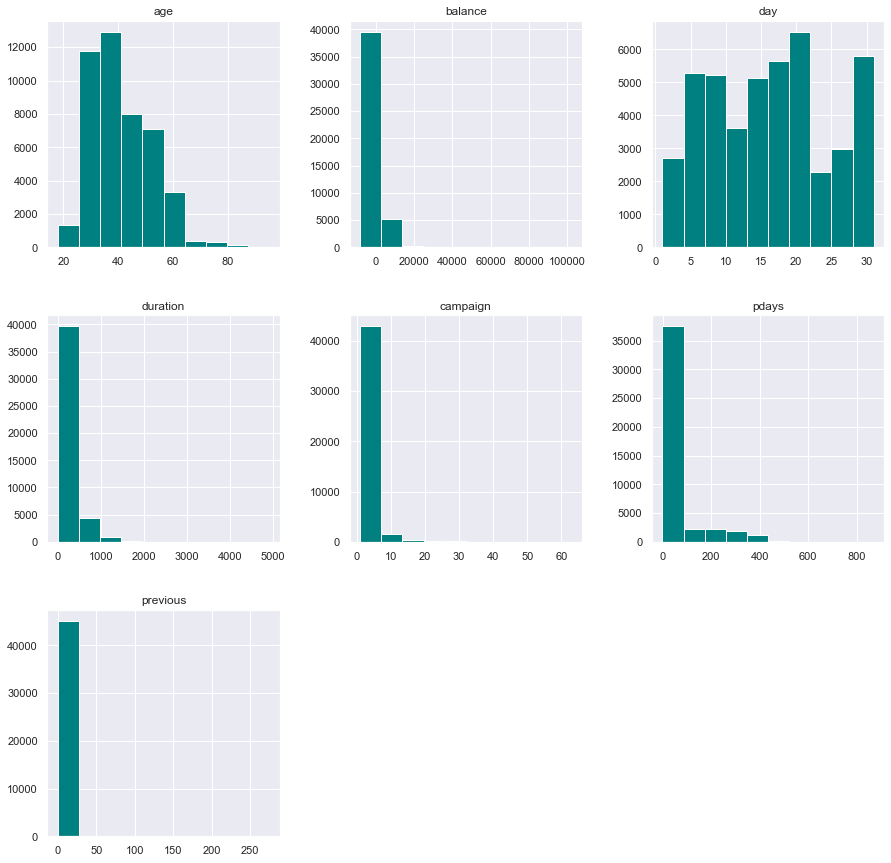

In [20]:
bank_full.hist(figsize=(15, 15),color='teal')

Most numerical variables (balance, duration, campaign, and pdays) are strongly skewed to the right. The 'previous' variable may also be skewed right. 'Age' appears to be slightly skewed right, while the 'day' variable appears to follow an approximate normal distribution. 